<a href="https://colab.research.google.com/github/A-Science-Company/EoTools/blob/main/VS_HSI_18_07_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import tarfile

# # Specify the path to your .tar.gz file
# tar_file_path = '/content/drive/MyDrive/ASCI/HS/ENMAP/dims_op_oc_oc-en_700808141_1.tar.gz'

# # Specify the directory where you want to extract the contents
# extract_dir = '/content/drive/MyDrive/ASCI/HS/ENMAP/'

# # Open the tarball file for reading
# with tarfile.open(tar_file_path, 'r:gz') as tar:
#     # Extract all the contents to the specified directory
#     tar.extractall(path=extract_dir)

# # Print a message indicating successful extraction
# print(f"Extracted contents to {extract_dir}")


In [ ]:
# zip_path = '/content/drive/MyDrive/ASCI/HS/ENMAP/ENMAP-HSI-L2ADT0000029759_01-2023-07-29T05:55:32.024637Z_exmachine144-cat1-A00002-P00139_700797731_722170559_2023-08-01T21:36:56/ENMAP01-____L2A-DT0000029759_20230729T055532Z_001_V010303_20230801T165359Z.ZIP'

In [ ]:
# import zipfile

# # Specify the path to your .zip file
# zip_file_path = zip_path = '/content/drive/MyDrive/ASCI/HS/ENMAP/ENMAP-HSI-L2ADT0000029759_01-2023-07-29T05:55:32.024637Z_exmachine144-cat1-A00002-P00139_700797731_722170559_2023-08-01T21:36:56/ENMAP01-____L2A-DT0000029759_20230729T055532Z_001_V010303_20230801T165359Z.ZIP'

# # Specify the directory where you want to extract the contents
# extract_dir = '/content/drive/MyDrive/ASCI/HS/ENMAP/'

# # Open the zip file for reading
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     # Extract all the contents to the specified directory
#     zip_ref.extractall(path=extract_dir)

# # Print a message indicating successful extraction
# print(f"Extracted contents to {extract_dir}")


##loading usgs data

In [ ]:
import json
import os
import pandas as pd

In [ ]:
json_path = "/content/drive/MyDrive/ASCI/USGS_library/organized_data/"
Fe_files=[]
for file_name in os.listdir(json_path):
  if file_name.split('.')[0] == 'mineral':
    with open(json_path+file_name) as json_file:
      data = json.load(json_file)
      if 'Fe' in data['CompoundName']:
        Fe_files.append(file_name)

In [ ]:
Fe_list = []
legend=[]
for i in Fe_files:
  with open(json_path+i) as json_file:
    data = json.load(json_file)
    df = pd.DataFrame(list(data['SpectralSignature'].items()), columns = ['wavelength', 'reflectance'])
    Fe_list.append(df)
    new_dict = data.copy()
    del new_dict['SpectralSignature']
    legend.append(new_dict)

In [ ]:
print (legend[100])
Fe_list[100]

{'CommonName': 'perkin', 'Name': 'Hematite alpha Fe_2O_3', 'Type': 'Mineral', 'Class': 'Oxide', 'SubClass': 'None', 'ParticleSize': 'Medium', 'SampleNo': 'O-1A', 'CompoundName': 'Fe_2O_3', 'Owner': 'JPL', 'Description': 'Particle size was 45-125um.Collected by:  Burminco Original ASTER Spectral Library name was jpl.perkin.mineral.oxide.none.medium.o01a.spectrum.txt', 'SpectralResolution': 'VSWIR'}


,wavelength,reflectance
0,400.0,6.6815
1,401.0,6.6902
2,402.0,6.6939
3,403.0,6.6974
4,404.0,6.7000
...,...,...
2096,2496.0,9.9960
2097,2497.0,10.3666
2098,2498.0,10.2812
2099,2499.0,10.1714


##loading ENMAP data

In [ ]:
!pip install rasterio
!pip install rioxarray
!pip install geotable

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 5.2 MB/s eta 0:00:00
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6085 sha256=6686b87e32bd60479beddf0d23381aa44b022526d904847d24c1c9d5841f4b6c
  Stored in directory: /root/.cache/pip/wheels/2f/a1/c8/543df0e8f5e824c3e92a432e32deb9cd89ae686095ee8cfcbe
Successfully built utm


In [ ]:
import rasterio
import rioxarray
import xml.etree.ElementTree as ET
import numpy as np
from shapely.geometry import Point, LineString, Polygon
import pyproj
import matplotlib.pyplot as plt
import glob
import geotable
import geopandas as gpd
from rasterio.features import geometry_mask
import plotly.express as px

In [ ]:
tree = ET.parse('/content/drive/MyDrive/ASCI/HS/ENMAP/ENMAP01-____L2A-DT0000023337_20230609T055926Z_002_V010301_20230610T044101Z/ENMAP01-____L2A-DT0000023337_20230609T055926Z_002_V010301_20230610T044101Z-METADATA.XML')
# tree = ET.parse('/content/drive/MyDrive/ASCI/image3/ENMAP01-____L2A-DT0000029759_20230729T055532Z_001_V010303_20230801T165359Z-METADATA.XML')
root = tree.getroot()

In [ ]:
band_statistics = root.find('specific/bandCharacterisation')
band_dict = {}
if band_statistics is not None:
    for element in band_statistics.iter('bandID'):
        number = element.attrib['number']
        wavelength = element.find('wavelengthCenterOfBand').text
        band_dict[number] = wavelength

print(band_dict)
hsi_wavelengths = list(band_dict.values())
wavelengths = []
for ld in hsi_wavelengths:
  wavelengths.append(int(float(ld)))

{'1': '418.416', '2': '424.043', '3': '429.457', '4': '434.686', '5': '439.758', '6': '444.699', '7': '449.539', '8': '454.306', '9': '459.031', '10': '463.73', '11': '468.411', '12': '473.08', '13': '477.744', '14': '482.411', '15': '487.087', '16': '491.78', '17': '496.497', '18': '501.243', '19': '506.02', '20': '510.829', '21': '515.672', '22': '520.551', '23': '525.467', '24': '530.424', '25': '535.422', '26': '540.463', '27': '545.551', '28': '550.687', '29': '555.873', '30': '561.112', '31': '566.405', '32': '571.756', '33': '577.166', '34': '582.636', '35': '588.171', '36': '593.773', '37': '599.446', '38': '605.193', '39': '611.017', '40': '616.923', '41': '622.921', '42': '628.987', '43': '635.112', '44': '641.294', '45': '647.537', '46': '653.841', '47': '660.207', '48': '666.637', '49': '673.131', '50': '679.691', '51': '686.319', '52': '693.014', '53': '699.78', '54': '706.617', '55': '713.524', '56': '720.501', '57': '727.545', '58': '734.654', '59': '741.826', '60': '749

In [ ]:
path = '/content/drive/MyDrive/ASCI/HS/ENMAP/ENMAP01-____L2A-DT0000023337_20230609T055926Z_002_V010301_20230610T044101Z/ENMAP01-____L2A-DT0000023337_20230609T055926Z_002_V010301_20230610T044101Z-SPECTRAL_IMAGE.TIF'
# path = '/content/drive/MyDrive/ASCI/image3/ENMAP01-____L2A-DT0000029759_20230729T055532Z_001_V010303_20230801T165359Z-SPECTRAL_IMAGE.TIF'
dataset = rioxarray.open_rasterio(path)/(10000)

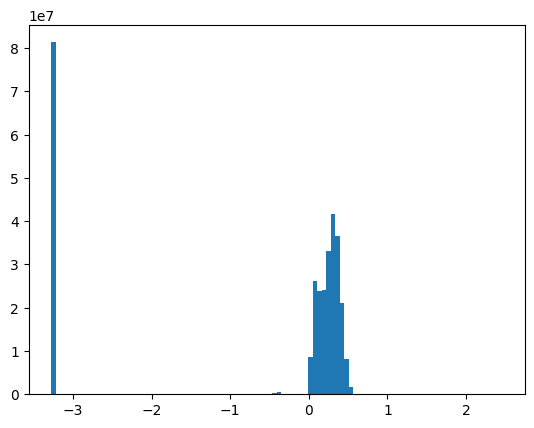

In [ ]:
plt.hist(dataset.values.flatten(), bins=100)
plt.show()

In [ ]:
coords = [(77.581514, 14.344822), (77.601144, 14.344822), (77.601144, 14.366206), (77.581514, 14.366206), (77.581514, 14.344822)]

In [ ]:
src_crs = pyproj.CRS.from_epsg(4326)
# target_crs = pyproj.CRS.from_epsg(32643)
target_crs = dataset.rio.crs
transformer = pyproj.Transformer.from_crs(src_crs, target_crs, always_xy=True)
target_bbox = []
for co in coords:
  target_bbox.append(transformer.transform(co[0], co[1]))

polygon = Polygon(target_bbox)

# Get the bounds of the polygon
bounds = polygon.bounds
bounds

(778415.7549336313, 1587417.3353303168, 780560.7899402368, 1589808.2789145391)

In [ ]:
dataset.rio.bounds()

(759585.0, 1564485.0, 795465.0, 1598925.0)

In [ ]:
dataset.shape

(224, 1148, 1196)

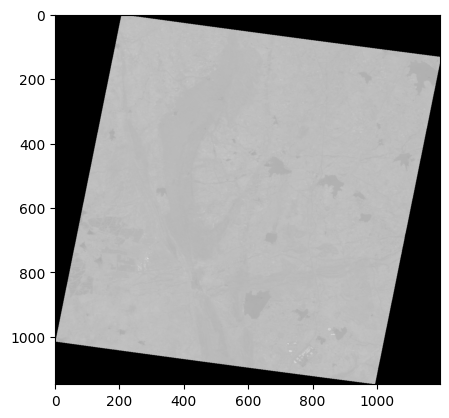

In [ ]:
plt.imshow(dataset[100,:,:],cmap='gray')

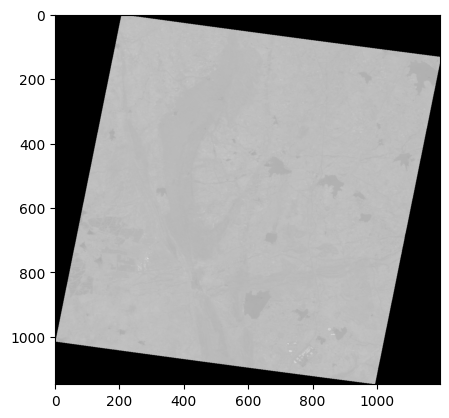

In [ ]:
plt.imshow(dataset[100,:,:],cmap='gray')

In [ ]:
all_phase_path = '/content/drive/MyDrive/ASCI/Anantgram/vectors/all_phases'
vector_file_list = sorted(glob.glob(os.path.join(all_phase_path, '*')))
vector_file_list

['/content/drive/MyDrive/ASCI/Anantgram/vectors/all_phases/phase_1.kmz',
 '/content/drive/MyDrive/ASCI/Anantgram/vectors/all_phases/phase_2.kmz',
 '/content/drive/MyDrive/ASCI/Anantgram/vectors/all_phases/phase_3.kmz',
 '/content/drive/MyDrive/ASCI/Anantgram/vectors/all_phases/phase_ff.kmz',
 '/content/drive/MyDrive/ASCI/Anantgram/vectors/all_phases/water_body_anantgram.kmz']

In [ ]:
#getting vector data
vector_data_list = []
for file_path in vector_file_list:
    data = geotable.load(file_path, drop_z=True).geometries[0].wkt
    vector_data_list.append(data)
#converting to tuples
polygon_list=[]
for data in vector_data_list:
  coords_str = data.replace('POLYGON ((', '').replace('))', '')
  coords_list = coords_str.split(', ')
  phase_1_coords = [tuple(map(float, coord.split())) for coord in coords_list]
  polygon_list.append(phase_1_coords)
#converting into required crs (raster_visual) and then adding shapely polygon in the last step
final_polygon_list = []
for poly in polygon_list:
  src_crs = pyproj.CRS.from_epsg(4326)
  # Define the target CRS (UTM zone 43N)
  epsg_code = int(str(dataset.rio.crs).split(":")[1])
  target_crs = pyproj.CRS.from_epsg(epsg_code)
  # Create a Transformer object to convert from one CRS to another
  transformer = pyproj.Transformer.from_crs(src_crs, target_crs, always_xy=True)
  transformed_coords = [transformer.transform(x, y) for x, y in poly]
  final_polygon_list.append(Polygon(transformed_coords))

In [ ]:
phase2 = final_polygon_list[1]

In [ ]:
print(phase2)

POLYGON ((779356.4654584273 1588437.3364813884, 779454.5442111082 1588515.5663575556, 779508.7495353259 1588504.968642812, 779587.6762698195 1588653.9611851305, 779692.2802668215 1588831.5713380445, 779561.2592644156 1588832.4763420513, 779589.6363771239 1588915.1653894929, 779507.97899548 1588979.658889792, 779481.6258822109 1588968.5867710817, 779478.0177579632 1589052.7345736313, 779315.4642150528 1588943.9753043514, 779252.2599496392 1588759.3398621446, 779271.8129290415 1588716.2035733038, 779220.8415115015 1588741.7438902496, 779244.6183250225 1588939.1433820091, 779096.5256857406 1588963.4178569044, 779047.6459862618 1588896.1148520638, 778915.5082684914 1588962.6009656296, 778909.5855227245 1588887.4425064167, 778995.5286704409 1588861.3436501115, 779046.6113497037 1588826.1536845486, 779061.1970328355 1588809.3432280438, 779063.9521722633 1588772.232694493, 779069.7225849775 1588747.3526696875, 779096.4202355945 1588703.9851287317, 779214.5657550339 1588727.021770808, 779227.1

In [ ]:
from shapely.geometry import mapping

# Convert Shapely polygon to GeoJSON-like geometry
phase2_geojson = mapping(phase2)
all_geojson = []
for p in final_polygon_list:
  all_geojson.append(mapping(p))

In [ ]:
type(phase2)

shapely.geometry.polygon.Polygon

In [ ]:
print(phase2)

POLYGON ((779356.4654584273 1588437.3364813884, 779454.5442111082 1588515.5663575556, 779508.7495353259 1588504.968642812, 779587.6762698195 1588653.9611851305, 779692.2802668215 1588831.5713380445, 779561.2592644156 1588832.4763420513, 779589.6363771239 1588915.1653894929, 779507.97899548 1588979.658889792, 779481.6258822109 1588968.5867710817, 779478.0177579632 1589052.7345736313, 779315.4642150528 1588943.9753043514, 779252.2599496392 1588759.3398621446, 779271.8129290415 1588716.2035733038, 779220.8415115015 1588741.7438902496, 779244.6183250225 1588939.1433820091, 779096.5256857406 1588963.4178569044, 779047.6459862618 1588896.1148520638, 778915.5082684914 1588962.6009656296, 778909.5855227245 1588887.4425064167, 778995.5286704409 1588861.3436501115, 779046.6113497037 1588826.1536845486, 779061.1970328355 1588809.3432280438, 779063.9521722633 1588772.232694493, 779069.7225849775 1588747.3526696875, 779096.4202355945 1588703.9851287317, 779214.5657550339 1588727.021770808, 779227.1

In [ ]:
# clipped_dataset = dataset.rio.clip(all_geojson)
clipped_dataset = dataset.rio.clip([phase2_geojson])
# clipped_dataset = dataset.rio.clip_box(*bounds)

In [ ]:
clipped_dataset.shape

(224, 21, 26)

In [ ]:
test = clipped_dataset[200,:,:]

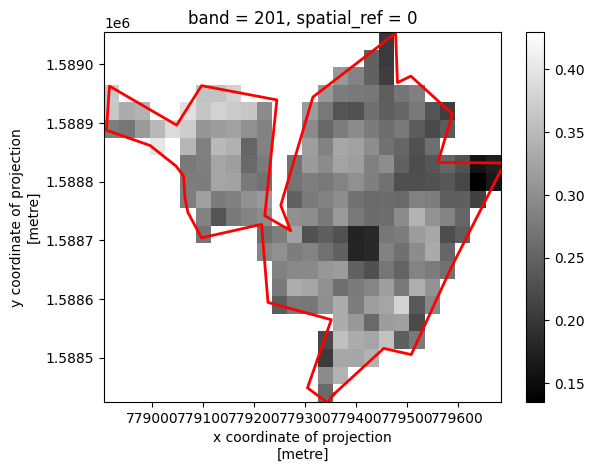

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon

# Create a figure and axis for the image
fig, ax = plt.subplots()

# Display the rioxarray image using imshow
test.plot.imshow(ax=ax, cmap='gray')

# Create a Shapely Polygon from the coordinates
shapely_polygon = phase2

# Extract x and y coordinates from the Shapely Polygon
x_coords, y_coords = shapely_polygon.exterior.xy

# Plot the extracted coordinates on top of the image
ax.plot(x_coords, y_coords, color='red', linewidth=2)

# Show the plot
plt.show()

In [ ]:
# clipped_band = band.rio.clip(polygon_list)
# clipped_dataset = test
# Create a mask for the clipped band using the polygon list.
mask = geometry_mask([phase2_geojson], out_shape=clipped_dataset.shape[-2:], transform=clipped_dataset.rio.transform(), invert=True)

# Add a new axis to the mask to align with the shape of clipped_band (1, y, x).
mask = mask[np.newaxis, :, :]

# Use numpy's where function to set the pixels outside the polygons to be transparent (alpha = 0).
clipped_dataset.data = np.where(mask, clipped_dataset.data, np.nan)

In [ ]:
clipped_dataset.shape

(224, 21, 26)

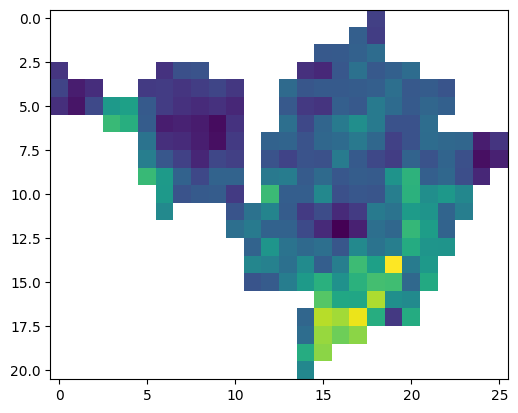

In [ ]:
plt.imshow(clipped_dataset[1,:,:])

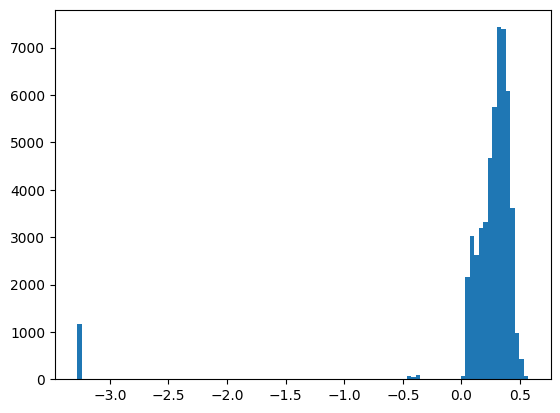

In [ ]:
plt.hist(clipped_dataset.values.flatten(), bins=100)
plt.show()

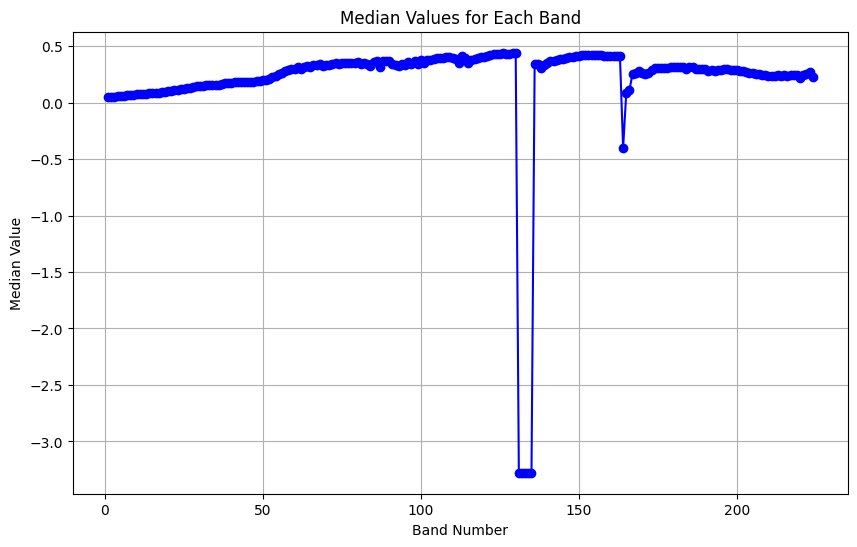

In [ ]:
# Calculate the median values for each band
median_values = np.nanmedian(clipped_dataset.data, axis=(1, 2))

# Create a list of band numbers (assuming bands are numbered from 1 to 224)
band_numbers = list(range(1, 225))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(band_numbers, median_values, marker='o', linestyle='-', color='b')
plt.xlabel('Band Number')
plt.ylabel('Median Value')
plt.title('Median Values for Each Band')
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np

# Calculate the median values for each band
median_values = np.nanmedian(clipped_dataset.data, axis=(1, 2))

# Calculate the minimum values for each band
min_values = np.nanmin(clipped_dataset.data, axis=(1, 2))

# Create a list of band numbers (assuming bands are numbered from 1 to 224)
band_numbers = list(range(1, 225))

# Create a Plotly figure
fig = go.Figure()

# Add the median values trace
fig.add_trace(go.Scatter(x=band_numbers, y=median_values, name='Median Value', mode='lines+markers'))

# Add the minimum values trace
fig.add_trace(go.Scatter(x=band_numbers, y=min_values, name='Minimum Value', mode='lines+markers'))

# Update layout with labels and title
fig.update_layout(xaxis_title='Band Number', yaxis_title='Value', title='Median and Minimum Values for Each Band')

# Show the Plotly figure
fig.show()


In [ ]:
min_values = np.nanmin(clipped_dataset.data, axis=(1, 2))

# Find the bands with the minimum values less than 0
bands_to_remove = np.where(min_values < 0)[0]

# Create a new dataset by removing the bands with minimum values less than 0
new_dataset = clipped_dataset.drop_sel(band=(bands_to_remove+1))


In [ ]:
bands_to_remove+1

array([131, 132, 133, 134, 135, 164, 165, 166])

In [ ]:
import plotly.graph_objects as go
# Calculate the median values for each band
median_values = np.nanmedian(new_dataset.data, axis=(1, 2))

# Calculate the minimum values for each band
min_values = np.nanmin(new_dataset.data, axis=(1, 2))

# Create a list of band numbers (assuming bands are numbered from 1 to 224)
band_numbers = list(range(1, 225))

# Create a Plotly figure
fig = go.Figure()

# Add the median values trace
fig.add_trace(go.Scatter(x=band_numbers, y=median_values, name='Median Value', mode='lines+markers'))

# Add the minimum values trace
fig.add_trace(go.Scatter(x=band_numbers, y=min_values, name='Minimum Value', mode='lines+markers'))

# Update layout with labels and title
fig.update_layout(xaxis_title='Band Number', yaxis_title='Value', title='Median and Minimum Values for Each Band')

# Show the Plotly figure
fig.show()


#creating a RGB image


In [ ]:
# Define the wavelength ranges for red, green, and blue
rgb_bands = {
    'Red': (649, 680),    # Adjust the wavelength ranges as needed
    'Green': (542, 578),  # Adjust the wavelength ranges as needed
    'Blue': (459, 525)    # Adjust the wavelength ranges as needed
}

# rgb_bands = {
#     'Red': (625, 740),    # Adjust the wavelength ranges as needed
#     'Green': (500, 565),  # Adjust the wavelength ranges as needed
#     'Blue': (450, 485)    # Adjust the wavelength ranges as needed
# }

# rgb_bands = {
#     'Red': (679, 686),    # Adjust the wavelength ranges as needed
#     'Green': (530, 535),  # Adjust the wavelength ranges as needed
#     'Blue': (465, 470)    # Adjust the wavelength ranges as needed
# }

# Initialize empty lists to store the band numbers
red_bands = []
green_bands = []
blue_bands = []

# Iterate through the band_dict dictionary and find bands in each range
for band_num, wavelength in band_dict.items():
    wavelength = float(wavelength)  # Convert the wavelength to a float
    for channel, (wavelength_start, wavelength_end) in rgb_bands.items():
        if wavelength_start <= wavelength <= wavelength_end:
            if channel == 'Red':
                red_bands.append(int(band_num))
            elif channel == 'Green':
                green_bands.append(int(band_num))
            elif channel == 'Blue':
                blue_bands.append(int(band_num))

# Print the band numbers for red, green, and blue
print("Red Bands:", red_bands)
print("Green Bands:", green_bands)
print("Blue Bands:", blue_bands)


Red Bands: [46, 47, 48, 49, 50]
Green Bands: [27, 28, 29, 30, 31, 32, 33]
Blue Bands: [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [ ]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# new_mask = mask.reshape(21,26)
# Extract the bands for the red channel
red_bands_data = clipped_dataset[red_bands, :, :]

# Calculate the average of the red channel bands
average_red_channel = np.mean(red_bands_data, axis=0)

# Normalize the average_red_channel to the [0, 255] range
average_red_channel = (average_red_channel - np.nanmin(average_red_channel)) / (np.nanmax(average_red_channel) - np.nanmin(average_red_channel)) * 255
# average_red_channel.data = np.where(new_mask, average_red_channel.data, np.nan)


# Extract the bands for the red channel
green_bands_data = clipped_dataset[green_bands, :, :]

# Calculate the average of the red channel bands
average_green_channel = np.mean(green_bands_data, axis=0)

# Normalize the average_red_channel to the [0, 255] range
average_green_channel = (average_green_channel - np.nanmin(average_green_channel)) / (np.nanmax(average_green_channel) - np.nanmin(average_green_channel)) * 255
# average_green_channel.data = np.where(new_mask, average_green_channel.data, np.nan)


# Extract the bands for the red channel
blue_bands_data = clipped_dataset[blue_bands, :, :]

# Calculate the average of the red channel bands
average_blue_channel = np.mean(blue_bands_data, axis=0)

# Normalize the average_red_channel to the [0, 255] range
average_blue_channel = (average_blue_channel - np.nanmin(average_blue_channel)) / (np.nanmax(average_blue_channel) - np.nanmin(average_blue_channel)) * 255
# average_blue_channel.data = np.where(new_mask, average_blue_channel.data, np.nan)

rgb_image = np.dstack((average_red_channel, average_green_channel, average_blue_channel)).astype(np.uint8)

# Assuming rgb_image has shape (81, 73, 3)
rgb_image_transpose = np.transpose(rgb_image, (2, 0, 1))

# Now, rgb_image has shape (3, 81, 73)
print(rgb_image_transpose.shape)

# # Create a figure and axis for the image
# fig, ax = plt.subplots()

# # Display the rioxarray image using imshow
# # rgb_image.plot.imshow(ax=ax)
# ax.imshow(rgb_image)

# # Create a Shapely Polygon from the coordinates
# shapely_polygon = phase2

# # Extract x and y coordinates from the Shapely Polygon
# x_coords, y_coords = shapely_polygon.exterior.xy

# # Plot the extracted coordinates on top of the image
# ax.plot(x_coords, y_coords, color='red', linewidth=2)

# # Show the plot
# plt.show()


(3, 21, 26)


In [ ]:
import xarray as xr

# Create a new DataArray for the RGB image
rgb_image_xr = xr.DataArray(
    rgb_image_transpose,
    dims=["band", "y", "x"],
    coords={
        "band": ["red", "green", "blue"],
        "y": average_red_channel.y,
        "x": average_red_channel.x,
    },
)

# Assign the CRS from the original rioxarray
rgb_image_xr.rio.write_crs(average_red_channel.rio.crs)

# Now rgb_image_xr is a rioxarray with the same CRS and coordinates as your original rioxarrays


<xarray.DataArray (band: 3, y: 21, x: 26)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)
Coordinates:
  * band         (band) <U5 'red' 'green' 'blue'
  * y            (y) float64 1.589e+06 1.589e+06 ... 1.588e+06 1.588e+06
  * x            (x) float64 7.789e+05 7.79e+05 7.79e+05 ... 7.796e+05 7.797e+05
    spatial_ref  int64 0

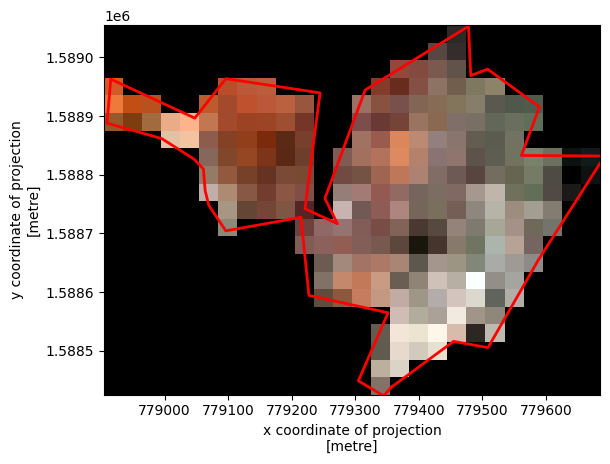

In [ ]:
# Create a figure and axis for the image
fig, ax = plt.subplots()

# Display the rioxarray image using imshow
rgb_image_xr.plot.imshow(ax=ax, cmap='gray')

# Create a Shapely Polygon from the coordinates
shapely_polygon = phase2

# Extract x and y coordinates from the Shapely Polygon
x_coords, y_coords = shapely_polygon.exterior.xy

# Plot the extracted coordinates on top of the image
ax.plot(x_coords, y_coords, color='red', linewidth=2)

# Show the plot
plt.show()

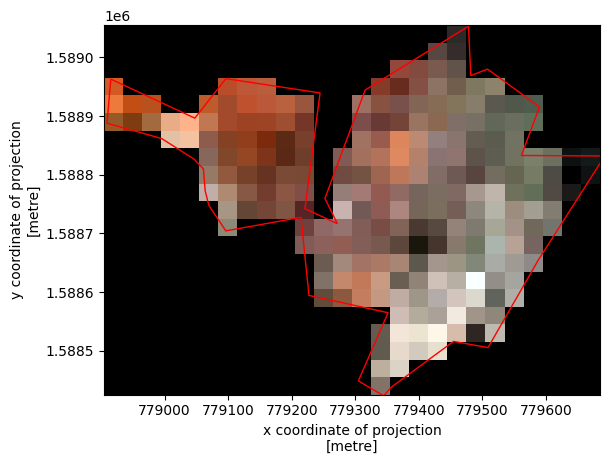

In [ ]:
import matplotlib.pyplot as plt


# Your existing code to create the RGB image
# ...

# Create a new figure and axes
fig, ax = plt.subplots()

# Display the rioxarray image using imshow
rgb_image_xr.plot.imshow(ax=ax)


# Extract the coordinates from phase2_geojson
coords = phase2_geojson['coordinates'][0]

# Create a Polygon object using the coordinates
polygon = Polygon(coords, fill=None, edgecolor='r')

# Add the polygon to the axes
ax.add_patch(polygon)

# Display the figure
plt.show()


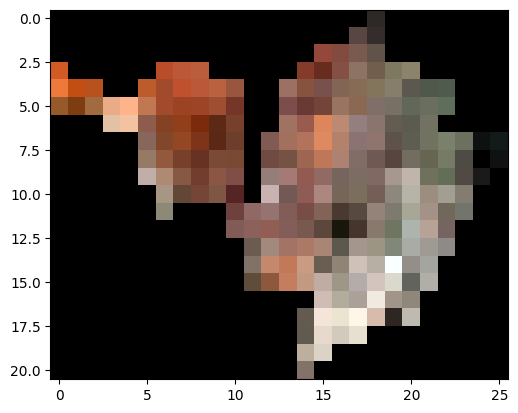

In [ ]:
plt.imshow(rgb_image)

In [ ]:
rgb_image.shape[1]

26

In [ ]:
import plotly.graph_objects as go

# Assuming rgb_image is your RGB image data
# Make sure rgb_image is a 3D numpy array with shape (3, height, width)

# Create a list of labels for the x-axis
x_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

# Create a Plotly figure
fig = go.Figure()

# Add the RGB image as a trace
fig.add_trace(go.Image(z=rgb_image, colormodel='rgb'))

# Customize the x and y axis labels
fig.update_xaxes(title_text="X Axis", ticktext=x_labels, tickvals=list(range(len(x_labels))))
fig.update_yaxes(title_text="Y Axis", tickvals=list(range(rgb_image.shape[1])))

# Set the initial width and height values
initial_width =20* rgb_image.shape[1]  # Set your desired initial width
initial_height = 20* rgb_image.shape[0]  # Set your desired initial height

# Double the plot size
fig.update_layout(
    title="RGB Image",
    width=2 * initial_width,  # Double the width
    height=2 * initial_height,  # Double the height
)

# Show the figure
fig.show()


In [ ]:
path_for_pixels = '/content/drive/MyDrive/ASCI/HS/phase2_data/pixels_final.xlsx'
# Read the Excel file into a pandas DataFrame
df = pd.read_excel(path_for_pixels)
print(df['Xs'])

0     O
1     O
2     P
3     Q
4     P
     ..
66    R
67    S
68    R
69    S
70    S
Name: Xs, Length: 71, dtype: object


In [ ]:
# Create a dictionary mapping 'A' to 0, 'B' to 1, 'C' to 2, and so on
alphabet_to_number = {chr(65 + i): i for i in range(26)}
alphabet_to_number
num = []
for x in df['Xs']:
  num.append(alphabet_to_number[x])
df['new_x'] = num
df

,Ys,Xs,Longitude,Latitude,new_x
0,20,O,NaN,NaN,14
1,19,O,NaN,NaN,14
2,19,P,NaN,NaN,15
3,18,Q,NaN,NaN,16
4,17,P,NaN,NaN,15
...,...,...,...,...,...
66,2,R,NaN,NaN,17
67,2,S,NaN,NaN,18
68,1,R,NaN,NaN,17
69,1,S,NaN,NaN,18


In [ ]:
pixels = list(zip(df['Ys'], df['new_x']))
pixels[0]

(20, 14)

In [ ]:
longitudes_in_m=[]
latitudes_in_m=[]
for i, p in enumerate(pixels):
  longitudes_in_m.append(float(rgb_image_xr[:,pixels[i][0],pixels[i][1]]['x']))
  latitudes_in_m.append(float(rgb_image_xr[:,pixels[i][0],pixels[i][1]]['y']))

In [ ]:
average_red_channel.rio.crs

CRS.from_epsg(32643)

In [ ]:
lat_lon_in_m = list(zip(latitudes_in_m,longitudes_in_m))
src_crs = average_red_channel.rio.crs
src_crs

CRS.from_epsg(32643)

In [ ]:
!pip install pyproj

In [ ]:
import pyproj

# Define the UTM CRS (assuming it's EPSG 32643)
utm_crs = pyproj.CRS.from_epsg(32643)

# Define the target geographic CRS
geographic_crs = pyproj.CRS("EPSG:4326")  # EPSG 4326 is WGS84

# Create a PyProj Transformer
transformer = pyproj.Transformer.from_crs(utm_crs, geographic_crs, always_xy=True)

# Convert the UTM coordinates to latitude and longitude
lat_lon_in_deg = [transformer.transform(lon, lat) for lat, lon in lat_lon_in_m]

# lat_lon_in_deg now contains latitude and longitude pairs
lat_lon_in_deg

[(77.5899377674024, 14.353968430447258),
 (77.58994088436071, 14.354239403639959),
 (77.59021883141007, 14.354236364694014),
 (77.59049989608492, 14.354504298489152),
 (77.59022506618919, 14.354778310939379),
 (77.59050301384066, 14.354775271548657),
 (77.59078096142699, 14.354772231832653),
 (77.59022818367643, 14.355049284051793),
 (77.59050613166148, 14.355046244601313),
 (77.59078407958144, 14.355043204825552),
 (77.59106202743627, 14.355040164724498),
 (77.59023130122876, 14.35532025715736),
 (77.59050924954745, 14.355317217647126),
 (77.59078719780102, 14.355314177811602),
 (77.59106514598946, 14.35531113765078),
 (77.59051236749853, 14.355588190686088),
 (77.59079031608573, 14.355585150790802),
 (77.59106826460781, 14.355582110570214),
 (77.59134621306475, 14.355579070024323),
 (77.59162416145655, 14.35557602915314),
 (77.59051548551473, 14.355859163718204),
 (77.59079343443557, 14.355856123763154),
 (77.59134933208183, 14.355850042877133),
 (77.59162728080729, 14.35584700194617

In [ ]:
# Separate the tuples into two lists
longitudes, latitudes = zip(*lat_lon_in_deg)

In [ ]:
final_df = df[['Ys','Xs']]
final_df['longitudes'] = longitudes
final_df['latitudes'] = latitudes

<ipython-input-105-fe0490eea4f1>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-105-fe0490eea4f1>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
final_df

,Ys,Xs,longitudes,latitudes
0,20,O,77.589938,14.353968
1,19,O,77.589941,14.354239
2,19,P,77.590219,14.354236
3,18,Q,77.590500,14.354504
4,17,P,77.590225,14.354778
...,...,...,...,...
66,2,R,77.590828,14.358837
67,2,S,77.591106,14.358834
68,1,R,77.590831,14.359108
69,1,S,77.591109,14.359105


In [ ]:
final_df.to_csv('final_long_lats.csv', index=False)


In [ ]:
from PIL import Image
import plotly.express as px

# Convert the RGB image to a PIL image
pil_image = Image.fromarray(rgb_image)

# Plot the PIL image using Plotly
fig = px.imshow(pil_image)

# Remove the axis labels and ticks
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)

# Show the Plotly figure
fig.show()


In [ ]:
rgb_image_with_mask.shape

(73, 55, 3)

In [ ]:
# new_mask = mask.reshape(21,26)
# Extract the bands for the red channel
red_bands_data = dataset[red_bands, :, :]

# Calculate the average of the red channel bands
average_red_channel = np.mean(red_bands_data, axis=0)

# Normalize the average_red_channel to the [0, 255] range
average_red_channel = (average_red_channel - np.nanmin(average_red_channel)) / (np.nanmax(average_red_channel) - np.nanmin(average_red_channel)) * 255
# average_red_channel.data = np.where(new_mask, average_red_channel.data, np.nan)


# Extract the bands for the red channel
green_bands_data = dataset[green_bands, :, :]

# Calculate the average of the red channel bands
average_green_channel = np.mean(green_bands_data, axis=0)

# Normalize the average_red_channel to the [0, 255] range
average_green_channel = (average_green_channel - np.nanmin(average_green_channel)) / (np.nanmax(average_green_channel) - np.nanmin(average_green_channel)) * 255
# average_green_channel.data = np.where(new_mask, average_green_channel.data, np.nan)


# Extract the bands for the red channel
blue_bands_data = dataset[blue_bands, :, :]

# Calculate the average of the red channel bands
average_blue_channel = np.mean(blue_bands_data, axis=0)

# Normalize the average_red_channel to the [0, 255] range
average_blue_channel = (average_blue_channel - np.nanmin(average_blue_channel)) / (np.nanmax(average_blue_channel) - np.nanmin(average_blue_channel)) * 255
# average_blue_channel.data = np.where(new_mask, average_blue_channel.data, np.nan)

rgb_image = np.dstack((average_red_channel, average_green_channel, average_blue_channel)).astype(np.uint8)


In [ ]:
rgb_image.shape

(1148, 1196, 3)

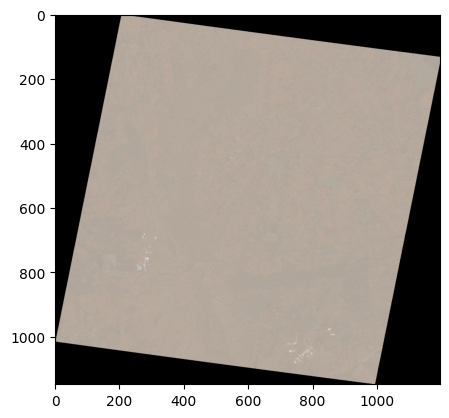

In [ ]:
plt.imshow(rgb_image)

In [ ]:
from PIL import Image
import plotly.express as px

# Convert the RGB image to a PIL image
pil_image = Image.fromarray(rgb_image)

# Plot the PIL image using Plotly
fig = px.imshow(pil_image)

# Remove the axis labels and ticks
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)

# Show the Plotly figure
fig.show()


In [ ]:
new_dataset.shape

(216, 21, 26)

In [ ]:
# Select the specific band (band 100, 0-based index)
band_100 = new_dataset[100, :, :]

# Count non-NaN pixels in the band
non_nan_pixels = np.count_nonzero(~np.isnan(band_100))

print(f"Number of non-NaN pixels in band 100: {non_nan_pixels}")

Number of non-NaN pixels in band 100: 233


In [ ]:
21*26

546

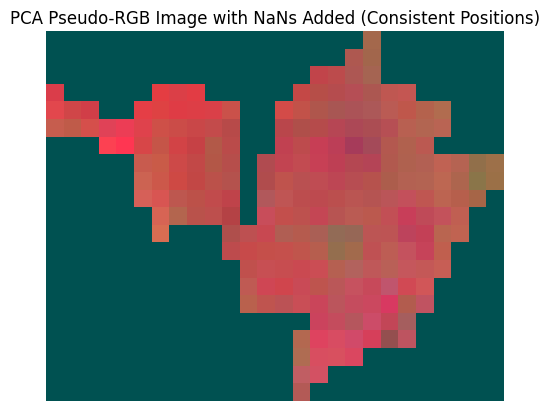

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Access the data from new_dataset
data_3d = new_dataset.values  # Shape: (216, 21, 26)

# Replace NaNs with zeros in the original hyperspectral data
data_3d[np.isnan(data_3d)] = 0

# Flatten the hyperspectral data (216 bands) into a 2D array (pixels x bands)
data_2d = data_3d.reshape((216, -1)).T

# Perform PCA on the data with zeros
n_components = 3
pca = PCA(n_components=n_components)
reduced_data = pca.fit_transform(data_2d)

# Reshape the reduced data to match the shape of (3, 21, 26)
reduced_data = reduced_data.T.reshape((n_components, 21, 26))

# Replace zeros back with NaNs in the reduced data for visualization
reduced_data[reduced_data == 0] = np.nan

# Normalize the values in the range [0, 1] for visualization
normalized_data = (reduced_data - np.nanmin(reduced_data)) / (np.nanmax(reduced_data) - np.nanmin(reduced_data))

# Display the reduced data as a pseudo-RGB image
plt.imshow(np.transpose(normalized_data, (1, 2, 0)))
plt.axis('off')
plt.title('PCA Pseudo-RGB Image with NaNs Added (Consistent Positions)')
plt.show()


In [ ]:
import numpy as np
import plotly.graph_objects as go
from sklearn.decomposition import PCA

# Access the data from new_dataset
data_3d = new_dataset.values  # Shape: (216, 21, 26)

# Replace NaNs with zeros in the original hyperspectral data
data_3d[np.isnan(data_3d)] = 0

# Flatten the hyperspectral data (216 bands) into a 2D array (pixels x bands)
data_2d = data_3d.reshape((216, -1)).T

# Perform PCA on the data with zeros
n_components = 3
pca = PCA(n_components=n_components)
reduced_data = pca.fit_transform(data_2d)

# Reshape the reduced data to match the shape of (3, 21, 26)
reduced_data = reduced_data.T.reshape((n_components, 21, 26))

# Replace zeros back with NaNs in the reduced data for visualization
reduced_data[reduced_data == 0] = np.nan

# Normalize the values in the range [0, 1] for visualization
normalized_data = (reduced_data - np.nanmin(reduced_data)) / (np.nanmax(reduced_data) - np.nanmin(reduced_data))

# Create a Plotly figure for visualization
fig = go.Figure(data=[
    go.Surface(z=normalized_data[0], colorscale='Viridis', showscale=False),
    go.Surface(z=normalized_data[1], colorscale='Viridis', showscale=False),
    go.Surface(z=normalized_data[2], colorscale='Viridis', showscale=False)
])

# Set layout properties
fig.update_layout(scene=dict(aspectratio=dict(x=1, y=1, z=0.7), xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                  title='PCA Pseudo-RGB Image with NaNs Added (Consistent Positions)')

# Show the Plotly figure
fig.show()


In [ ]:
import numpy as np
import plotly.graph_objects as go
from sklearn.decomposition import PCA

# Access the data from new_dataset
data_3d = new_dataset.values  # Shape: (216, 21, 26)

# Replace NaNs with zeros in the original hyperspectral data
data_3d[np.isnan(data_3d)] = 0

# Flatten the hyperspectral data (216 bands) into a 2D array (pixels x bands)
data_2d = data_3d.reshape((216, -1)).T

# Perform PCA on the data with zeros
n_components = 1
pca = PCA(n_components=n_components)
reduced_data = pca.fit_transform(data_2d)

# Reshape the reduced data to match the shape of (3, 21, 26)
reduced_data = reduced_data.T.reshape((n_components, 21, 26))

# Replace zeros back with NaNs in the reduced data for visualization
reduced_data[reduced_data == 0] = np.nan

# Normalize the values in the range [0, 255] for RGB
normalized_data = (reduced_data - np.nanmin(reduced_data)) / (np.nanmax(reduced_data) - np.nanmin(reduced_data)) * 255

# Create an RGB array
rgb_array = np.zeros((21, 26, 3), dtype=np.uint8)
rgb_array[..., 0] = normalized_data[0]
rgb_array[..., 1] = normalized_data[0]
rgb_array[..., 2] = normalized_data[0]

# Create a Plotly figure for visualization
fig = go.Figure()

# Add the RGB-like image as an image trace
fig.add_trace(go.Image(z=rgb_array))

# Set layout properties
fig.update_layout(xaxis_title='X', yaxis_title='Y', title='PCA Pseudo-RGB Image with NaNs Added (Consistent Positions)')

# Show the Plotly figure
fig.show()


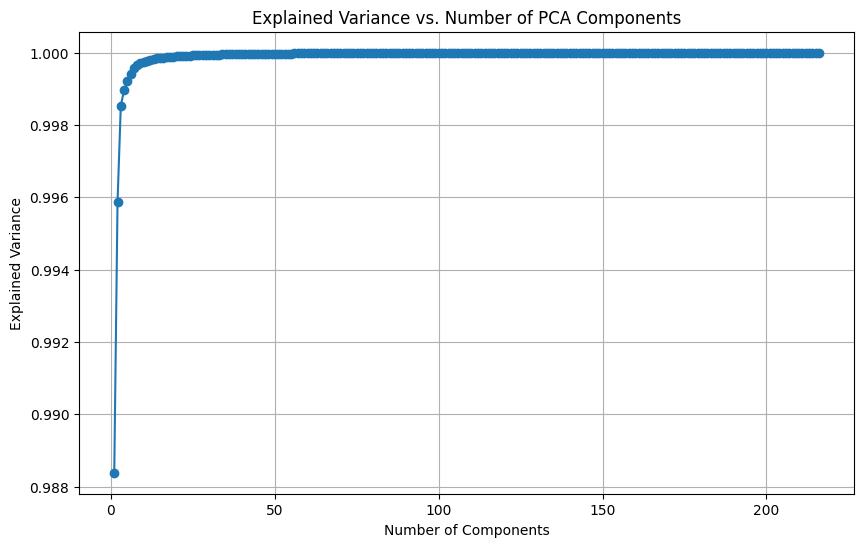

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Access the data from new_dataset
data_3d = new_dataset.values  # Shape: (216, 21, 26)

# Replace NaNs with zeros in the original hyperspectral data
data_3d[np.isnan(data_3d)] = 0

# Flatten the hyperspectral data (216 bands) into a 2D array (pixels x bands)
data_2d = data_3d.reshape((216, -1)).T

# Create a list to store explained variances
explained_variances = []

# Perform PCA for different numbers of components
for n_components in range(1, 217):  # Try a range of component numbers
    pca = PCA(n_components=n_components)
    pca.fit(data_2d)
    explained_variances.append(np.sum(pca.explained_variance_ratio_))

# Plot the explained variances
plt.figure(figsize=(10, 6))
plt.plot(range(1, 217), explained_variances, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs. Number of PCA Components')
plt.grid(True)
plt.show()


In [ ]:
all_bands = dataset.copy()
all_bands.shape

(224, 81, 73)

In [ ]:
import plotly.express as px
# Get the shape of the data (assuming it's in the format (height, width))
height, width = data.shape[-2], data.shape[-1]

# Create a grayscale heatmap using go.Figure
fig = go.Figure(data=go.Heatmap(z=dataset[0].values, colorscale='gray'))

# Calculate the figure size to maintain the aspect ratio
fig_height = 500  # Set your desired height
fig_width = int(width * (fig_height / height))

# Update the figure's size
fig.update_layout(
    title="Grayscale Raster",
    xaxis_title="X-axis",
    yaxis_title="Y-axis",
    width=fig_width,
    height=fig_height,
    yaxis=dict(autorange="reversed")   # Reverse the y-axis
)

# Show the plot
fig.show()

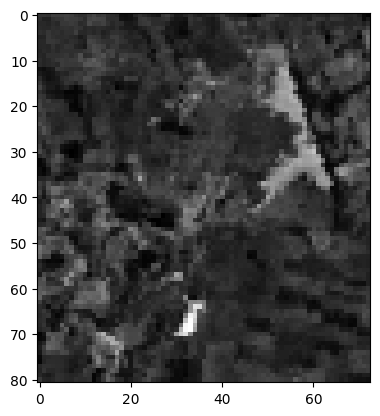

In [ ]:
plt.imshow(dataset[0], cmap='gray')

In [ ]:
# pixxel_100_200 = all_bands[:,100,200]
# pixxel_100_200_f = np.where(pixxel_100_200 < 0, np.nan, pixxel_100_200)

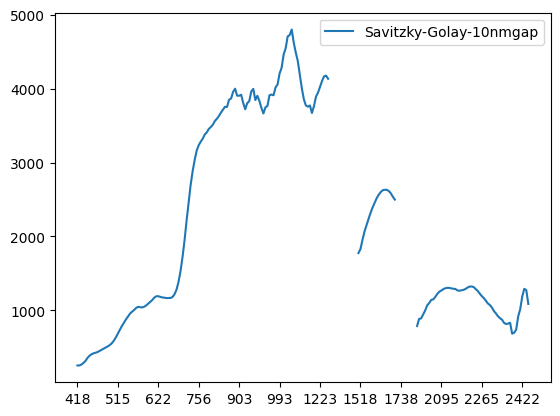

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Assuming pixxel_100_200_f contains your original data
y = pixxel_100_200_f

# add noise to the signal
# noise = 0.05 * np.random.normal(size=len(x))
# y_noise = y + noise

# apply the Savitzky-Golay filter
y_sg = savgol_filter(y, window_length=5, polyorder=3)
y_sg2 = savgol_filter(y, window_length=10, polyorder=3)

# Plot all 224 wavelengths but label every 10th wavelength on the x-axis
x_indices_to_label = np.arange(0, 224, 20)  # Label every 10th wavelength

plt.plot(hsi_wavelengths, y_sg2, label='Savitzky-Golay-10nmgap')
plt.xticks(x_indices_to_label, [int(wavelengths[i]) for i in x_indices_to_label])
plt.legend()
plt.show()


###plotting ENMAP using plotly

In [ ]:
layer_100 = all_bands[100,:,:]
layer_100.shape

(81, 73)

In [ ]:
print(type(layer_100))

<class 'xarray.core.dataarray.DataArray'>


In [ ]:
import plotly.graph_objects as go
import numpy as np

# Assuming layer_100 is your numpy array
# You can specify the x and y coordinates as well as the values for the heatmap
fig = go.Figure(data=go.Heatmap(z=layer_100, colorscale='gray'))

# You can customize the appearance of the heatmap as needed
fig.update_layout(
    title="Layer 100 Heatmap",
    xaxis_title="X-axis",
    yaxis_title="Y-axis",
    xaxis=dict(scaleanchor="y", scaleratio=layer_100.shape[0]/layer_100.shape[1]),  # Set aspect ratio for the x-axis
    coloraxis_showscale=False  # To remove the color scale bar
)

# Show the plot
fig.show()

In [ ]:
#soil
Soil type (sand / clay)
calcite
NPK
Carbon biomass
sulphur
mangnasite
sulfate minerals,
carbonate minerals,
iron oxides,
silica
pH

#plant
coconut
mango
teak
pomo

#water



In [ ]:
#pixel selection
#test_pixel = layer_100['y','x']

In [ ]:
legend[100]['CompoundName']

'Fe_2O_3'

###pixel vs USGS comparision

In [ ]:
import numpy as np
import plotly.graph_objs as go
from scipy.signal import savgol_filter

# Define the pixel's surface reflectance
pixxel_100_200 = all_bands[:, 100, 200]
pixxel_100_200_f = np.where(pixxel_100_200 < 0, np.nan, pixxel_100_200)

# Define the known material's hyperspectral signatures (Fe_list[100], Fe_list[150], and Fe_list[200])
fe_wavelengths_100 = Fe_list[100]['wavelength']
fe_reflectance_100 = Fe_list[100]['reflectance']
fe_wavelengths_150 = Fe_list[150]['wavelength']
fe_reflectance_150 = Fe_list[150]['reflectance']
fe_wavelengths_200 = Fe_list[200]['wavelength']
fe_reflectance_200 = Fe_list[200]['reflectance']

# Normalize the y-values of the pixel's surface reflectance and Fe_list data
pixxel_100_200_f_normalized = (pixxel_100_200_f - np.nanmin(pixxel_100_200_f)) / (np.nanmax(pixxel_100_200_f) - np.nanmin(pixxel_100_200_f))
fe_reflectance_100_normalized = (fe_reflectance_100 - np.nanmin(fe_reflectance_100)) / (np.nanmax(fe_reflectance_100) - np.nanmin(fe_reflectance_100))
fe_reflectance_150_normalized = (fe_reflectance_150 - np.nanmin(fe_reflectance_150)) / (np.nanmax(fe_reflectance_150) - np.nanmin(fe_reflectance_150))
fe_reflectance_200_normalized = (fe_reflectance_200 - np.nanmin(fe_reflectance_200)) / (np.nanmax(fe_reflectance_200) - np.nanmin(fe_reflectance_200))

# Apply the Savitzky-Golay filter to the pixel's surface reflectance
x_pixxel = wavelengths
y_pixxel = pixxel_100_200_f_normalized
y_sg2 = savgol_filter(y_pixxel, window_length=10, polyorder=3)

# Create a Plotly figure with four traces
fig = go.Figure()

# Add traces for the pixel's surface reflectance and Fe_list data
fig.add_trace(go.Scatter(x=x_pixxel, y=y_sg2, mode='lines+markers', name='Pixel Surface Reflectance (Normalized)'))
fig.add_trace(go.Scatter(x=fe_wavelengths_100, y=fe_reflectance_100_normalized, mode='lines', name=legend[100]['CompoundName']))
fig.add_trace(go.Scatter(x=fe_wavelengths_150, y=fe_reflectance_150_normalized, mode='lines', name=legend[150]['CompoundName']))
fig.add_trace(go.Scatter(x=fe_wavelengths_200, y=fe_reflectance_200_normalized, mode='lines', name=legend[200]['CompoundName']))

# Customize the plot layout
fig.update_layout(
    title='Comparison of Pixel and Known Material Hyperspectral Signatures',
    xaxis_title='Wavelength (nm)',
    yaxis_title='Normalized Reflectance (0-1)',
    legend=dict(x=0, y=1),
    xaxis=dict(showgrid=True),  # Show x-axis grid lines
    yaxis=dict(showgrid=True),  # Show y-axis grid lines
)

# Show the interactive plot
fig.show()


In [ ]:
fe_wavelengths

0        400.0
1        401.0
2        402.0
3        403.0
4        404.0
         ...  
2096    2496.0
2097    2497.0
2098    2498.0
2099    2499.0
2100    2500.0
Name: wavelength, Length: 2101, dtype: object

##back to work

In [ ]:
np.max(all_bands)

16516

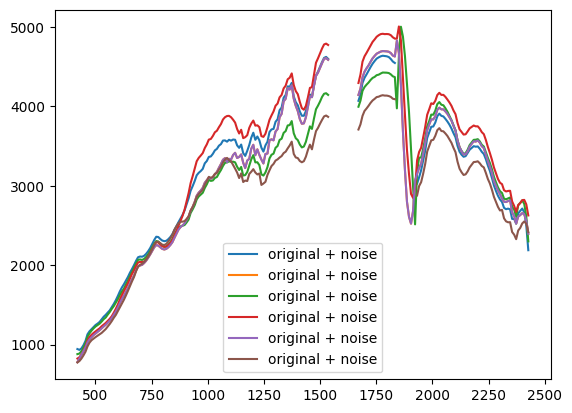

In [ ]:
pixxel_x_y = all_bands[:,120,241]
pixxel_x_y_f = np.where(pixxel_x_y < 0, np.nan, pixxel_x_y)

x = result
y = pixxel_x_y_f

pixxel_x_y = all_bands[:,120,240]
pixxel_x_y_f = np.where(pixxel_x_y < 0, np.nan, pixxel_x_y)

y2 = pixxel_x_y_f

pixxel_x_y = all_bands[:,120,239]
pixxel_x_y_f = np.where(pixxel_x_y < 0, np.nan, pixxel_x_y)

y3 = pixxel_x_y_f

pixxel_x_y = all_bands[:,119,240]
pixxel_x_y_f = np.where(pixxel_x_y < 0, np.nan, pixxel_x_y)

y4 = pixxel_x_y_f

pixxel_x_y = all_bands[:,120,240]
pixxel_x_y_f = np.where(pixxel_x_y < 0, np.nan, pixxel_x_y)

y5 = pixxel_x_y_f

pixxel_x_y = all_bands[:,121,240]
pixxel_x_y_f = np.where(pixxel_x_y < 0, np.nan, pixxel_x_y)

y6 = pixxel_x_y_f


import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# define the original signal
start = 420
end = 2450
num_buckets = 224

bucket_size = round((end - start) / num_buckets)
result = [start + i * bucket_size for i in range(num_buckets)]

# add noise to the signal
#noise = 0.05 * np.random.normal(size=len(x))
#y_noise = y + noise

# apply the Savitzky-Golay filter
#y_sg = savgol_filter(y, window_length=5, polyorder=3)
y_sg21 = savgol_filter(y, window_length=5, polyorder=3)
y_sg22 = savgol_filter(y2, window_length=5, polyorder=3)
y_sg23 = savgol_filter(y3, window_length=5, polyorder=3)
y_sg24 = savgol_filter(y4, window_length=5, polyorder=3)
y_sg25 = savgol_filter(y5, window_length=5, polyorder=3)
y_sg26 = savgol_filter(y6, window_length=10, polyorder=3)



# plot the original and filtered signals
#plt.plot(x, y, label='original + noise')
#plt.plot(x, y2, label='original + noise')
#plt.plot(x, y3, label='original + noise')

#plt.plot(x, y_sg, label='Savitzky-Golay--5nmgap')
plt.plot(x, y_sg21, label='original + noise')
plt.plot(x, y_sg22, label='original + noise')
plt.plot(x, y_sg23, label='original + noise')
plt.plot(x, y_sg24, label='original + noise')
plt.plot(x, y_sg25, label='original + noise')
plt.plot(x, y_sg26, label='original + noise')



plt.legend()
plt.show()



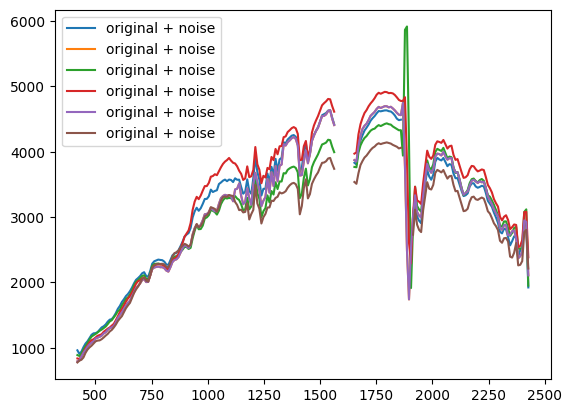

In [ ]:
#Need to be able to visualize which pixel am i viewing
#Need to be able to compare spectral signature of the repository of minerals vs the chosen pixel
#Need to estimate spectral angular mapper between 2 spectras
#Need to understand how to do spectral unmixing; endmember detection
